# TONG CODE

# Imports and Version Checking

In [1]:
import librosa
from librosa import display
import sklearn
import numpy as np
import torch

# python version
import sys
print("Python version: " + sys.version)

# librosa version
print("Librosa version: " + librosa.__version__)

# sklearn
print("Sklearn version: " + sklearn.__version__)

# torch
print("Torch version: " + torch.__version__)

/home/tzhao/.local/lib/python3.6/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


Python version: 3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]
Librosa version: 0.7.1
Sklearn version: 0.21.3
Torch version: 1.0.1.post2


# Data Loading

In [2]:
# from brendan

from sklearn.model_selection import train_test_split

all_genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
num_songs = 100
Y_LIMIT = 660000

In [3]:
# Loads n_songs songs from each genre in load_genres.  
def load_dataset(genres=all_genres, n_songs=num_songs):
    X, Y = None, None
    for g_idx, g in enumerate(genres):
        for s_idx in range(n_songs):
            y, sr = librosa.load(f'genres/{g}/{g}.000{s_idx:02d}.au')
            # Limit length of sample so that all features have the same length.
            y = y[:Y_LIMIT]
            mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13).flatten()
            
            if X is None:
                X = mfcc.reshape(1, mfcc.shape[0])
                Y = np.array([[g_idx]])
                
            else:
                X = np.vstack([X, mfcc])
                Y = np.vstack([Y, np.array([[g_idx]])])
    return X, Y

In [4]:
%%time
X, Y = load_dataset(all_genres, 100)
Y = Y.ravel()

CPU times: user 10min 3s, sys: 9min 30s, total: 19min 34s
Wall time: 6min 2s


In [5]:
print(X.shape, Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(1000, 16770) (1000,)
(750, 16770) (250, 16770) (750,) (250,)


## PyTorch DataLoader

In [26]:
# making torch style dataset and dataloader

from torch.utils.data import Dataset, DataLoader

class MusicDataset(Dataset):

    def __init__(self, X, Y):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)

    def __len__(self):
        assert(self.X.size()[0] == self.Y.size()[0])
        return self.X.size()[0]

    def __getitem__(self, index):
        data = self.X[index,].reshape((1,self.X.size()[1]))
        
        # normalizing
        data = (data - data.mean())/data.std()
        
        label = self.Y[index]
        return (data, label)
    
trainset = MusicDataset(X_train, Y_train)
testset = MusicDataset(X_test, Y_test)

print(len(trainset))
print(len(testset))

genre_trainloader = DataLoader(trainset, batch_size = 64, shuffle = True)
genre_testloader = DataLoader(testset, batch_size = 64, shuffle = False)

750
250


# Models

In [27]:
import torch.nn as nn
import torch.nn.functional as F
import math
from torchsummary import summary

## CNN

In [44]:
# attempt at regularization

class WeightClipper():

    def __init__(self):
        pass

    def __call__(self, module):
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = w.clamp(-1,1)

In [28]:
class Conv_Block(nn.Module):
    
    def __init__(self, in_planes, planes, kernel_size, stride, pool_size):
        
        super(Conv_Block, self).__init__()
        
        self.conv = nn.Conv1d(in_channels = in_planes, out_channels = planes, kernel_size = kernel_size, stride=stride)
        self.dropout = nn.Dropout(p=0.5)
        self.maxpool = nn.MaxPool1d(kernel_size = pool_size)
        self.bnorm = nn.BatchNorm1d(num_features = planes)
    
    def forward(self, x):
        
        x = self.conv(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        x = self.bnorm(x)
        x = F.relu(x)
        
        return x

class Conv(nn.Module):
    
    def __init__(self, params):    
        super(Conv, self).__init__()
        
        filters = params['filters']
        kernel_sizes = params['kernel_sizes']
        strides = params['strides']
        max_pool_sizes = params['max_pool_sizes']
        
        assert(len(filters) == len(kernel_sizes))
        assert(len(filters) == len(strides))
        assert(len(filters) == len(max_pool_sizes))
        
        prev_outplanes = 1
        prev_outsize = params['input_length']
        
        layers = []
        
        for i in range(len(filters)):
            inplanes = prev_outplanes
            outplanes = inplanes * filters[i]
            out_size = math.floor((math.floor((prev_outsize - kernel_sizes[i]) / float(strides[i]))+\
                                1)/float(max_pool_sizes[i]))
            
            prev_outsize = out_size
            prev_outplanes = outplanes
            
            new_block = Conv_Block(inplanes, outplanes, kernel_sizes[i], strides[i], max_pool_sizes[i])
            
            layers.append(new_block)
            
        self.convs = nn.Sequential(*layers)
        
        in_features = prev_outsize * prev_outplanes
        
        self.fc = nn.Linear(in_features = in_features, out_features = 10)
        
    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

In [62]:
# Debugging

# big big convnet
conv_params = {
    'input_length' : 16770,
    'filters' : [8, 8, 8, 4],
    'kernel_sizes' : [64, 32, 16, 8],
    'strides' : [8, 4, 2, 1],
    'max_pool_sizes' : [2, 2, 2, 2]
}

# smaller convnet
# conv_params = {
#     'input_length' : 16770,
#     'filters' : [8, 16, 64],
#     'kernel_sizes' : [64, 8, 4],
#     'strides' : [8, 4, 2],
#     'max_pool_sizes' : [16, 4, 2]
# }

# smallest convnet
# conv_params = {
#     'input_length' : 16770,
#     'filters' : [8, 64],
#     'kernel_sizes' : [64, 4],
#     'strides' : [8, 2],
#     'max_pool_sizes' : [32, 4]
# }

# observation: this net works as long as we don't run out of elements to convolute across (no padding)

conv_test = Conv(conv_params)
clipper = WeightClipper()
conv_test.apply(clipper)
summary(conv_test, (1,16770))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 8, 2089]             520
           Dropout-2              [-1, 8, 2089]               0
         MaxPool1d-3              [-1, 8, 1044]               0
       BatchNorm1d-4              [-1, 8, 1044]              16
        Conv_Block-5              [-1, 8, 1044]               0
            Conv1d-6              [-1, 64, 254]          16,448
           Dropout-7              [-1, 64, 254]               0
         MaxPool1d-8              [-1, 64, 127]               0
       BatchNorm1d-9              [-1, 64, 127]             128
       Conv_Block-10              [-1, 64, 127]               0
           Conv1d-11              [-1, 512, 56]         524,800
          Dropout-12              [-1, 512, 56]               0
        MaxPool1d-13              [-1, 512, 28]               0
      BatchNorm1d-14              [-1, 

## DCNN

In [30]:
class DConv_Block(nn.Module):
    
    def __init__(self, in_planes, planes, kernel_size, dialation, pool_size):
        
        super(DConv_Block, self).__init__()
        
        padding = int((kernel_size + (kernel_size - 1)*(dialation - 1) - 1)/2)
        
        self.dconv = nn.Conv1d(in_channels = in_planes, out_channels = planes,
                               kernel_size = kernel_size, stride=1, padding=padding, dilation=dialation)
        self.dropout = nn.Dropout(p=0.5)
        self.avgpool = nn.AvgPool1d(kernel_size = pool_size)
        self.bnorm = nn.BatchNorm1d(num_features = planes)
    
    def forward(self, x):
        x = self.dconv(x)
        x = self.dropout(x)
        x = self.avgpool(x)
        x = self.bnorm(x)
        x = F.relu(x)
        return x

class DConv(nn.Module):
    
    def __init__(self, params):    
        super(DConv, self).__init__()
        
        self.dc_unit_1 = DConv_Block(1, params['num_filters_1'], params['ker_size_1'],
                                     params['dialation_1'], params['avg_pool_size_1'])
        
        self.dc_unit_2 = DConv_Block(params['num_filters_1'], params['num_filters_1']*params['num_filters_2'],
                                     params['ker_size_2'], params['dialation_2'], params['avg_pool_size_2'])
        
        in_features = params['num_filters_1'] * params['num_filters_2'] * \
            math.floor(math.floor(params['input_length']/params['avg_pool_size_1'])/params['avg_pool_size_2'])
        
        self.fc = nn.Linear(in_features = in_features, out_features = 10)
        
    def forward(self, x):
        x = self.dc_unit_1(x)
        x = self.dc_unit_2(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x


In [61]:
# Debugging
dconv_params = {
    'input_length' : 16770,
    'num_filters_1' : 16,
    'ker_size_1' : 64,
    'dialation_1' : 8,
    'avg_pool_size_1' : 32,
    'num_filters_2' : 64,
    'ker_size_2' : 16,
    'dialation_2' : 2,
    'avg_pool_size_2' : 4
}

# observation: this net works as long as dialation_2 is even

dconv_test = DConv(dconv_params)
summary(dconv_test, (1,16770))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 16, 16770]           1,040
           Dropout-2            [-1, 16, 16770]               0
         AvgPool1d-3              [-1, 16, 524]               0
       BatchNorm1d-4              [-1, 16, 524]              32
       DConv_Block-5              [-1, 16, 524]               0
            Conv1d-6            [-1, 1024, 524]         263,168
           Dropout-7            [-1, 1024, 524]               0
         AvgPool1d-8            [-1, 1024, 131]               0
       BatchNorm1d-9            [-1, 1024, 131]           2,048
      DConv_Block-10            [-1, 1024, 131]               0
           Linear-11                   [-1, 10]       1,341,450
Total params: 1,607,738
Trainable params: 1,607,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forw

## Training and Testing Code

In [50]:
# defining training and testing functions

def train(net, criterion, optimizer, num_epochs, trainloader):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    net.train()
    
    for epoch in range(num_epochs):
        
        correct = 0
        total = 0
        
        print("Epoch: " + str(epoch+1))
        running_loss = 0.0
        for data in trainloader:
            
            inputs, labels = data
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = net(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()            
            running_loss += loss.item()
            
        print("Loss: " + str(running_loss / 750.0) + ' Accuracy: ' + str((100 * correct / total)) + '%')
    print('Finished Training')

def test(net, testloader):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    net.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    # todo: calculate length of testloader instead of hardcoding
            
    print('Accuracy of the network on 250 test datapoints: ' + str((100 * correct / total)) + '%')

# Evaluating Models

In [33]:
# from brendan
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(test_labels, predictions, title):
    ax= plt.subplot()
    cm = confusion_matrix(test_labels, predictions)
    sns.heatmap(cm, annot=True, ax = ax, cmap = sns.cm.rocket_r); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title(f'{title} Confusion Matrix'); 
    ax.set_ylim(top=0, bottom=10)
    ax.xaxis.set_ticklabels(all_genres); ax.yaxis.set_ticklabels(all_genres);
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    plt.show()

In [34]:
# test_labels = Y_test

def net_confusion_matrix(net, testloader, test_labels, title):
    
    separate_predictions = []
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    net.eval()
    
    with torch.no_grad():
        for data in testloader:
            
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            separate_predictions.append(predicted.numpy())
    
    predictions = np.concatenate(separate_predictions)
    plot_confusion_matrix(test_labels, predictions, title)            

In [64]:
conv_net = Conv(conv_params)

# regularizing
conv_net.apply(clipper)

conv_crit = nn.CrossEntropyLoss()
conv_opt = torch.optim.Adam(conv_net.parameters(), lr=0.001)

In [65]:
dconv_net = DConv(dconv_params)

# regularizing
dconv_net.apply(clipper)

dconv_crit = nn.CrossEntropyLoss()
dconv_opt = torch.optim.Adam(dconv_net.parameters(), lr=0.001)

In [ ]:
%%time
# training and evaluating CNN

train(conv_net, conv_crit, conv_opt, 20, genre_trainloader)
test(conv_net, genre_testloader)
net_confusion_matrix(conv_net, genre_testloader, Y_test, "Preliminary CNN")

Epoch: 1
Loss: 0.03788559691111247 Accuracy: 22.4%
Epoch: 2
Loss: 0.028636907259623208 Accuracy: 31.866666666666667%
Epoch: 3
Loss: 0.02570577843983968 Accuracy: 39.2%
Epoch: 4
Loss: 0.024613877455393472 Accuracy: 44.13333333333333%
Epoch: 5
Loss: 0.02444011131922404 Accuracy: 43.6%
Epoch: 6
Loss: 0.023384923775990805 Accuracy: 46.13333333333333%
Epoch: 7
Loss: 0.02133247439066569 Accuracy: 50.53333333333333%
Epoch: 8
Loss: 0.021374799887339275 Accuracy: 50.666666666666664%
Epoch: 9


Epoch: 1
Loss: 0.03319073390960693 Accuracy: 25.066666666666666%
Epoch: 2
Loss: 0.02751227617263794 Accuracy: 37.06666666666667%
Epoch: 3
Loss: 0.024791409492492675 Accuracy: 44.53333333333333%
Epoch: 4
Loss: 0.022774714310963947 Accuracy: 48.13333333333333%
Epoch: 5
Loss: 0.021381651242574056 Accuracy: 53.06666666666667%
Epoch: 6
Loss: 0.0199297571182251 Accuracy: 56.8%
Epoch: 7
Loss: 0.0180342538356781 Accuracy: 62.93333333333333%
Epoch: 8
Loss: 0.01667971595128377 Accuracy: 65.73333333333333%
Epoch: 9
Loss: 0.015877511262893676 Accuracy: 68.8%
Epoch: 10
Loss: 0.014604349215825398 Accuracy: 71.2%
Epoch: 11
Loss: 0.013744022130966187 Accuracy: 73.2%
Epoch: 12
Loss: 0.013037107706069946 Accuracy: 74.26666666666667%
Epoch: 13
Loss: 0.012122730016708374 Accuracy: 77.06666666666666%
Epoch: 14
Loss: 0.01102952524026235 Accuracy: 77.86666666666666%
Epoch: 15
Loss: 0.011160833915074666 Accuracy: 78.66666666666667%
Epoch: 16
Loss: 0.009664595564206442 Accuracy: 81.6%
Epoch: 17
Loss: 0.0087875

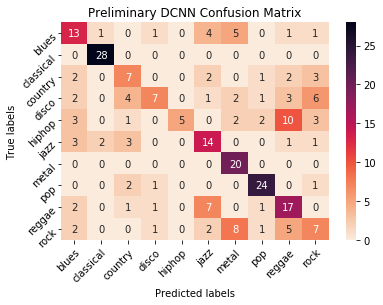

CPU times: user 18min 43s, sys: 12min 14s, total: 30min 57s
Wall time: 9min 46s


In [60]:
%%time
# training and evaluating DCNN

train(dconv_net, dconv_crit, dconv_opt, 20, genre_trainloader)
test(dconv_net, genre_testloader)
net_confusion_matrix(dconv_net, genre_testloader, Y_test, "Preliminary DCNN")

TODO:

- make CNN (done)
- make RNN
- test all of those and tune hyperparameters
- get a gpu?